# Reconnaissance des signalisations routières

<img src="https://saferautohome.files.wordpress.com/2019/04/traffic-signs-gtsdb.png?w=1400">

Il existe plusieurs datasets de "traffic signs", cf par exemple :  
https://saferauto.home.blog/2019/04/03/3o-databases-for-traffic-signs-detection/  
Ou :  
https://github.com/dctian/DeepPiCar/tree/master/models/object_detection/data/images/train  
(avec identification des zones pour de la détection d'objet)

On va utiliser ici un dataset Kaggle :  
https://www.kaggle.com/valentynsichkar/traffic-signs-preprocessed

## Importation des librairies

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AvgPool2D, BatchNormalization, Reshape

In [68]:
# Lecture du répertoire Kaggle
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/traffic-signs-preprocessed/data8.pickle
/kaggle/input/traffic-signs-preprocessed/data4.pickle
/kaggle/input/traffic-signs-preprocessed/test.pickle
/kaggle/input/traffic-signs-preprocessed/std_rgb.pickle
/kaggle/input/traffic-signs-preprocessed/data5.pickle
/kaggle/input/traffic-signs-preprocessed/data3.pickle
/kaggle/input/traffic-signs-preprocessed/mean_image_gray.pickle
/kaggle/input/traffic-signs-preprocessed/labels.pickle
/kaggle/input/traffic-signs-preprocessed/data1.pickle
/kaggle/input/traffic-signs-preprocessed/mean_image_rgb.pickle
/kaggle/input/traffic-signs-preprocessed/valid.pickle
/kaggle/input/traffic-signs-preprocessed/data0.pickle
/kaggle/input/traffic-signs-preprocessed/std_gray.pickle
/kaggle/input/traffic-signs-preprocessed/data6.pickle
/kaggle/input/traffic-signs-preprocessed/label_names.csv
/kaggle/input/traffic-signs-preprocessed/datasets_preparing.py
/kaggle/input/traffic-signs-preprocessed/data7.pickle
/kaggle/input/traffic-signs-preprocessed/train

## Lecture des données

Les données sont encodées avec Pickle :  
https://docs.python.org/3/library/pickle.html

In [4]:
import pickle

On lit le fichier "data3.pickle" qui contient les images prétraitées

In [5]:
with open('../input/traffic-signs-preprocessed/data3.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

In [6]:
X_train = data['x_train']
y_train = data['y_train']

In [7]:
X_train.shape

(86989, 3, 32, 32)

In [8]:
X_train = X_train.transpose(0,2,3,1)

In [9]:
X_train.shape

(86989, 32, 32, 3)

X_train contient alors 86989 lignes d'images, codées en 3 couleurs, de taille 32x32 pixels chacune.

In [10]:
y_train.shape

(86989,)

In [11]:
y_train[0]

37

In [12]:
labels = ['Speed limit (20km/h)',
 'Speed limit (30km/h)',
 'Speed limit (50km/h)',
 'Speed limit (60km/h)',
 'Speed limit (70km/h)',
 'Speed limit (80km/h)',
 'End of speed limit (80km/h)',
 'Speed limit (100km/h)',
 'Speed limit (120km/h)',
 'No passing',
 'No passing for vehicles over 3.5 metric tons',
 'Right-of-way at the next intersection',
 'Priority road',
 'Yield',
 'Stop',
 'No vehicles',
 'Vehicles over 3.5 metric tons prohibited',
 'No entry',
 'General caution',
 'Dangerous curve to the left',
 'Dangerous curve to the right',
 'Double curve',
 'Bumpy road',
 'Slippery road',
 'Road narrows on the right',
 'Road work',
 'Traffic signals',
 'Pedestrians',
 'Children crossing',
 'Bicycles crossing',
 'Beware of ice/snow',
 'Wild animals crossing',
 'End of all speed and passing limits',
 'Turn right ahead',
 'Turn left ahead',
 'Ahead only',
 'Go straight or right',
 'Go straight or left',
 'Keep right',
 'Keep left',
 'Roundabout mandatory',
 'End of no passing',
 'End of no passing by vehicles over 3.5 metric tons']

In [13]:
len(labels)

43

On a alors 43 signes à distinguer.

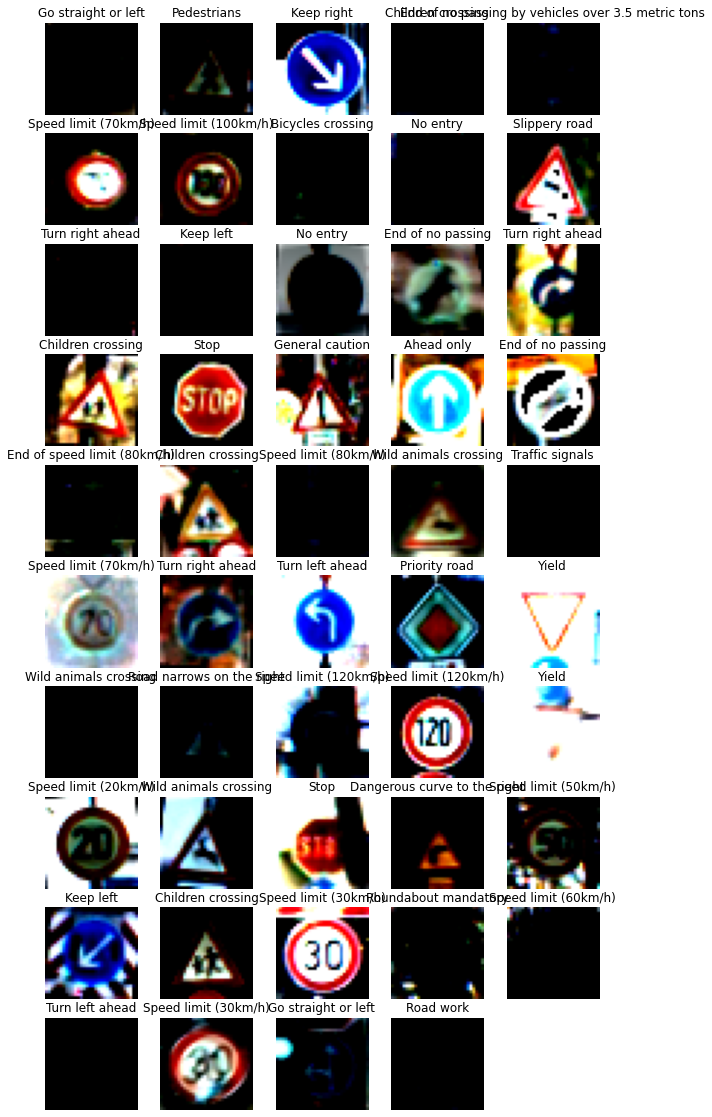

In [14]:
plt.figure(figsize=(10,20))
for i in range(0,49) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X_train[i])
    plt.title(labels[y_train[i]])

In [15]:
X_test = data['x_test'].transpose(0,2,3,1)
y_test = data['y_test']

In [16]:
num_classes = len(labels) # 43

## Exercice : utiliser les réseaux convolutionnels, et ensuite le transfer learning pour reconnaître les signalisations routières

In [82]:
unique_elements, counts_elements = np.unique(y_test, return_counts=True)
print("Comptage des valeurs :")
print(np.asarray((unique_elements, counts_elements)))

Comptage des valeurs :
[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
   36  37  38  39  40  41  42]
 [ 60 720 750 450 660 630 150 450 450 480 660 420 690 720 270 210 150 360
  390  60  90  90 120 150  90 480 180  60 150  90 150 270  60 210 120 390
  120  60 690  90  90  60  90]]


On transforme la cible en forme binaire 

In [17]:
y_train1 = to_categorical(y_train)
y_test1 = to_categorical(y_test)

Normalisation entre 0 et 1

In [18]:
X_train = X_train / 255
X_test = X_test / 255

In [19]:
y_test1[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## Une couche convolutionnelle

On va utiliser utiliser une couche convolutionnelle pour l'extraction des caractéristiques, et une couche dense pour la classification :

In [86]:
# Réseau convolutionnel simple
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

# Compilation du modèle
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

On peut afficher la structure du modèle :

In [87]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
flatten_4 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 43)                1238443   
Total params: 1,239,339
Trainable params: 1,239,339
Non-trainable params: 0
_________________________________________________________________


**Apprentissage**

In [88]:
# Apprentissage
train = model.fit(X_train, y_train1, validation_data=(X_test, y_test1), epochs=20, batch_size=200, verbose=1)
# on met bien y_test1 qui contient le tableau des 1 et 0

Epoch 1/20
435/435 [==============================] - 3s 7ms/step - loss: 2.2788 - accuracy: 0.4501 - val_loss: 1.5530 - val_accuracy: 0.5994
Epoch 2/20
435/435 [==============================] - 2s 5ms/step - loss: 1.1829 - accuracy: 0.7314 - val_loss: 1.2092 - val_accuracy: 0.6995
Epoch 3/20
435/435 [==============================] - 2s 5ms/step - loss: 0.9033 - accuracy: 0.8013 - val_loss: 1.0965 - val_accuracy: 0.7267
Epoch 4/20
435/435 [==============================] - 2s 5ms/step - loss: 0.7523 - accuracy: 0.8367 - val_loss: 1.0206 - val_accuracy: 0.7629
Epoch 5/20
435/435 [==============================] - 2s 5ms/step - loss: 0.6507 - accuracy: 0.8620 - val_loss: 0.9729 - val_accuracy: 0.7660
Epoch 6/20
435/435 [==============================] - 2s 5ms/step - loss: 0.5781 - accuracy: 0.8780 - val_loss: 0.9463 - val_accuracy: 0.7759
Epoch 7/20
435/435 [==============================] - 2s 5ms/step - loss: 0.5209 - accuracy: 0.8900 - val_loss: 0.8992 - val_accuracy: 0.8004
Epoch 

In [89]:
# Test
scores = model.evaluate(X_test, y_test1, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 82.92%


On obtient alors un score assez bon.

On définit une fonction pour afficher un graphique des scores :

In [48]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

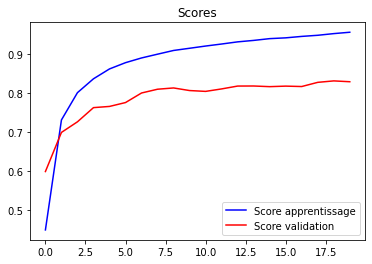

In [91]:
plot_scores(train)

In [92]:
# Prediction
y_cnn = model.predict_classes(X_test)

On affiche 40 images où l'algorithme s'est trompé :

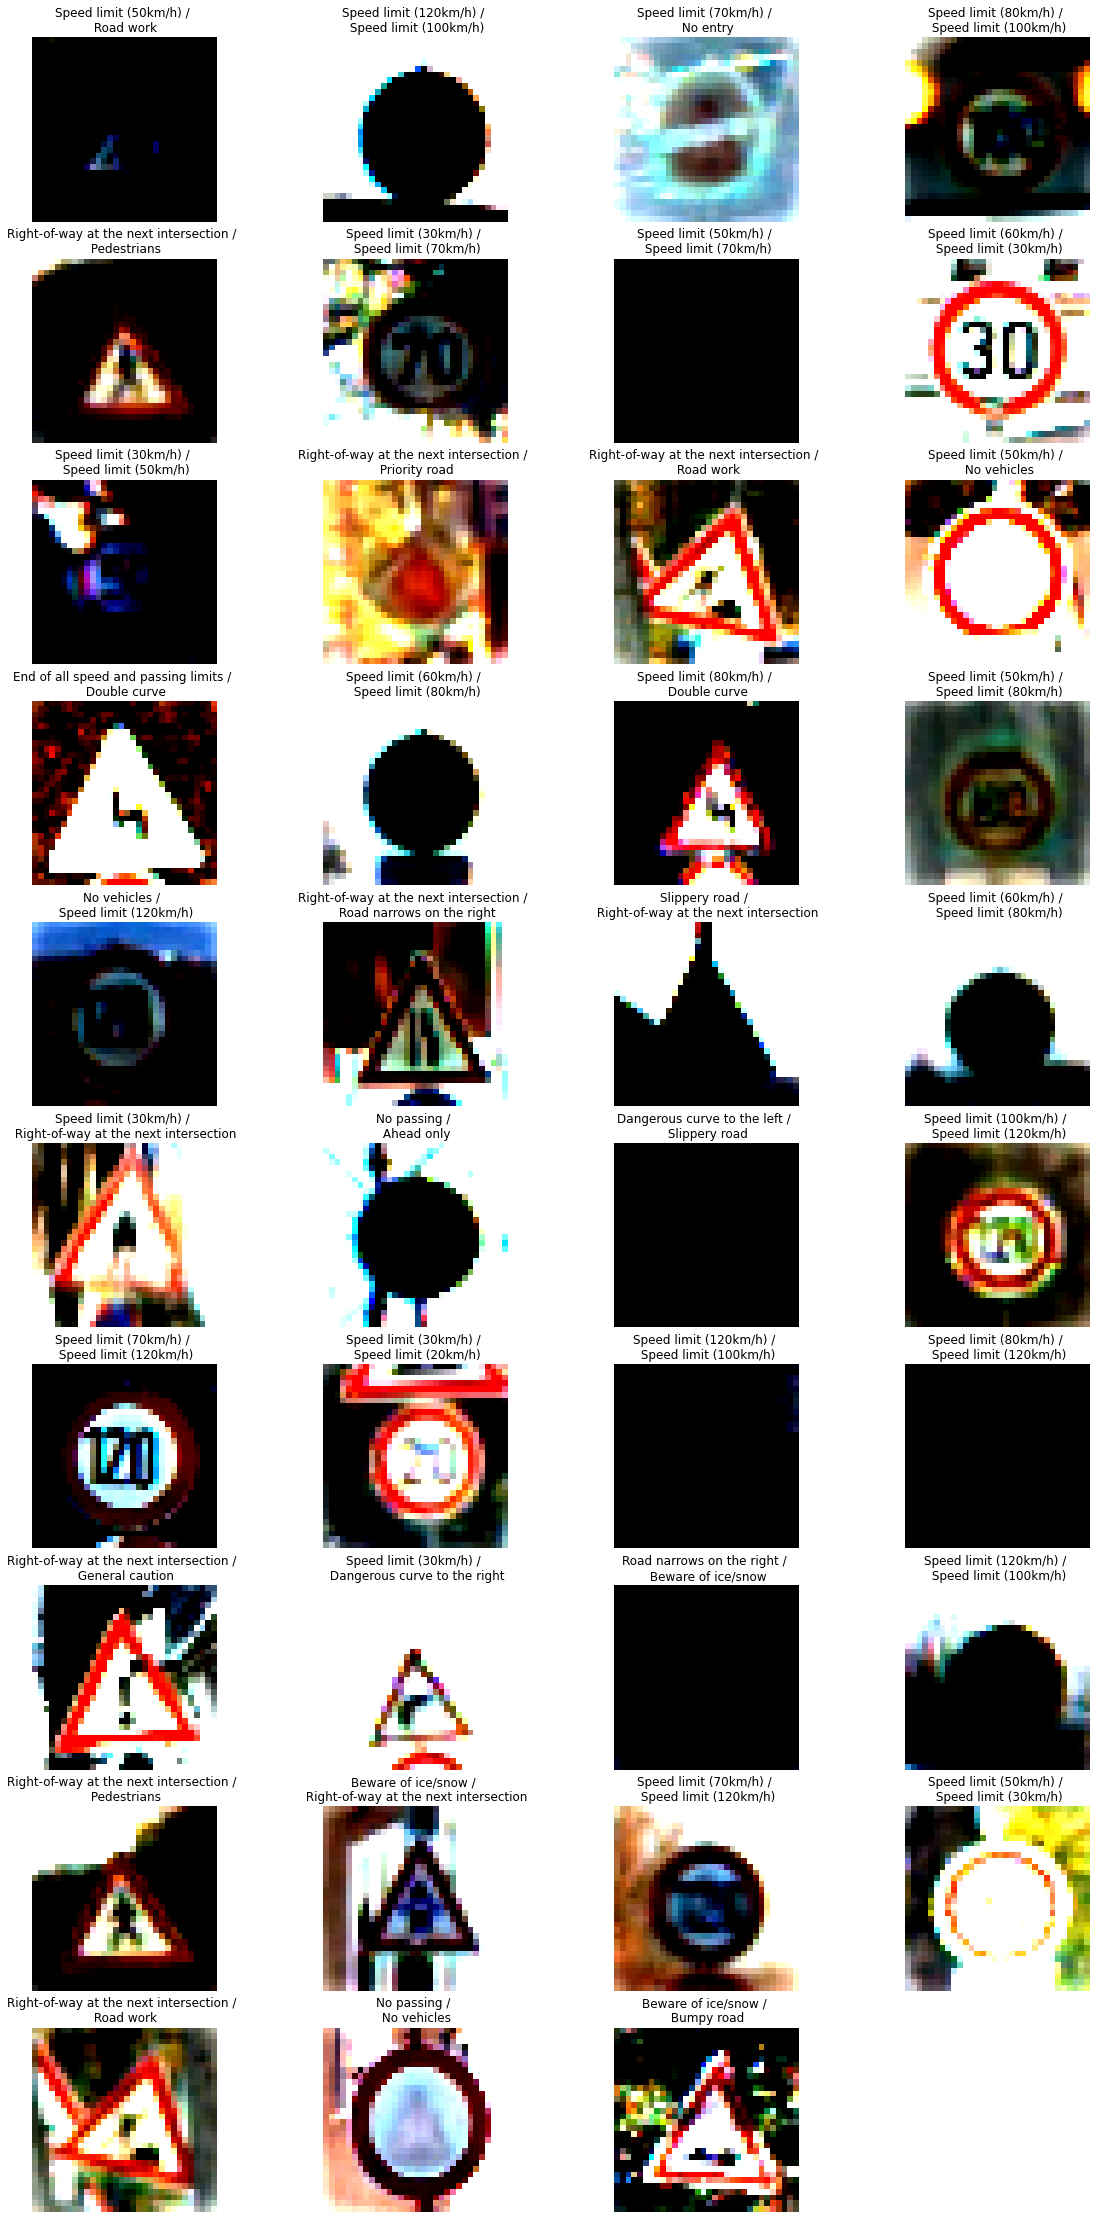

In [93]:
plt.figure(figsize=(20,40))
n_test = X_test.shape[0]
i=1
for j in range(len(X_test)) :
    if (y_cnn[j] != y_test[j]) & (i<40):
        plt.subplot(10,4,i)
        plt.axis('off')
        plt.imshow(X_test[j]*255)
        pred_classe = y_cnn[j].argmax(axis=-1)
        plt.title('%s / \n %s' % (labels[int(y_cnn[j])], labels[int(y_test[j])]))
        i+=1
        


## Modèle CNN plus profond

On teste un modèle avec plus de couches convolutionnelles :

*rappel*: maxpool: permet de diminuer la taille des images dropout : permet de minimiser le surapprentissage

In [94]:
# Modèle CNN plus profond
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(20, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compilation du modèle
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [95]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)         

**Apprentissage**

In [96]:
# Apprentissage
train = model.fit(X_train, y_train1, validation_data=(X_test, y_test1), epochs=40, batch_size=200, verbose=1)

# Test
scores = model.evaluate(X_test, y_test1, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Epoch 1/40
435/435 [==============================] - 4s 10ms/step - loss: 2.9919 - accuracy: 0.1940 - val_loss: 1.7502 - val_accuracy: 0.5008
Epoch 2/40
435/435 [==============================] - 4s 9ms/step - loss: 1.6967 - accuracy: 0.5008 - val_loss: 1.1701 - val_accuracy: 0.6471
Epoch 3/40
435/435 [==============================] - 4s 9ms/step - loss: 1.2793 - accuracy: 0.6135 - val_loss: 0.8194 - val_accuracy: 0.7690
Epoch 4/40
435/435 [==============================] - 4s 9ms/step - loss: 1.0145 - accuracy: 0.6899 - val_loss: 0.6408 - val_accuracy: 0.8215
Epoch 5/40
435/435 [==============================] - 4s 9ms/step - loss: 0.8510 - accuracy: 0.7414 - val_loss: 0.5267 - val_accuracy: 0.8546
Epoch 6/40
435/435 [==============================] - 4s 10ms/step - loss: 0.7232 - accuracy: 0.7801 - val_loss: 0.4396 - val_accuracy: 0.8738
Epoch 7/40
435/435 [==============================] - 4s 10ms/step - loss: 0.6257 - accuracy: 0.8119 - val_loss: 0.3792 - val_accuracy: 0.8935
Epo

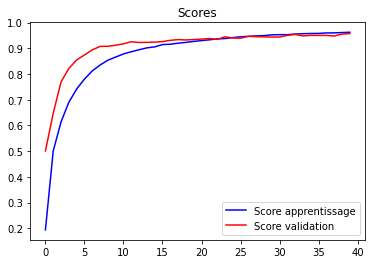

In [97]:
plot_scores(train)

Le modèle entrainé peut être sauvegardé :

In [98]:
model.save('mnist_cnn2.h5')  # le fichier contient des poids

On peut ensuite utiliser le modèle sans recommencer l'entraînement :

In [99]:
from keras.models import load_model
new_model = load_model('mnist_cnn2.h5')
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)         

In [100]:
scores = new_model.evaluate(X_test, y_test1, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 95.68%


On obtient alors un score assez élevé: ~ 95%

## Transfer learning

On va utiliser un modèle prédéfini dans Keras (VGG16) :

In [20]:
from keras.applications import VGG16

On utilise les poids pré-entraînés sur ImageNet (un million d'images) On "fige" le réseau VGG16, de manière à ne pas refaire l'entraînement sur le dataset particulier

In [38]:
vgg16 = VGG16(weights= 'imagenet', include_top=False, input_shape=(32,32,3))
vgg16.trainable = False

In [33]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

On ajoute des couches pour entraîner le modèle à partir du dataset, sans modifier les poids existants du VGG16 :

In [39]:
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(125, activation='relu'))
model.add(Dense(43, activation='softmax'))

# Compilation du modèle
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 125)               64125     
_________________________________________________________________
dense_12 (Dense)             (None, 43)                5418      
Total params: 15,046,887
Trainable params: 332,199
Non-trainable params: 14,714,688
_________________________________________________________________


In [41]:
train = model.fit(X_train, y_train1, validation_data=(X_test, y_test1), epochs=20, batch_size=200, verbose=1)


Epoch 1/20
435/435 [==============================] - 8s 18ms/step - loss: 3.7624 - accuracy: 0.0222 - val_loss: 3.7609 - val_accuracy: 0.0071
Epoch 2/20
435/435 [==============================] - 7s 17ms/step - loss: 3.7614 - accuracy: 0.0223 - val_loss: 3.7618 - val_accuracy: 0.0071
Epoch 3/20
435/435 [==============================] - 7s 17ms/step - loss: 3.7614 - accuracy: 0.0220 - val_loss: 3.7621 - val_accuracy: 0.0071
Epoch 4/20
435/435 [==============================] - 7s 17ms/step - loss: 3.7614 - accuracy: 0.0217 - val_loss: 3.7619 - val_accuracy: 0.0166
Epoch 5/20
435/435 [==============================] - 7s 17ms/step - loss: 3.7614 - accuracy: 0.0226 - val_loss: 3.7620 - val_accuracy: 0.0071
Epoch 6/20
435/435 [==============================] - 8s 18ms/step - loss: 3.7614 - accuracy: 0.0223 - val_loss: 3.7610 - val_accuracy: 0.0546
Epoch 7/20
435/435 [==============================] - 7s 17ms/step - loss: 3.7614 - accuracy: 0.0223 - val_loss: 3.7610 - val_accuracy: 0.0546

In [42]:
# Test
scores = model.evaluate(X_test, y_test1, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 1.19%


**Commentaire** : On remarque que le score est assez mauvais, ce qui peut s'expliquer par le fait que le dataset Imagenet ne s'est pas entrainé suffisamment sur les panneaux de signalisation.

On peut dégeler les dernières couches.

In [43]:
for layer in vgg16.layers[15:]:
    layer.trainable=True
for layer in vgg16.layers[0:15]:
    layer.trainable=False

In [44]:
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(125, activation='relu'))
model.add(Dense(43, activation='softmax'))

# Compilation du modèle
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
train = model.fit(X_train, y_train1, validation_data=(X_test, y_test1), epochs=20, batch_size=200, verbose=1)

Epoch 1/20
435/435 [==============================] - 8s 18ms/step - loss: 3.7627 - accuracy: 0.0225 - val_loss: 3.7601 - val_accuracy: 0.0546
Epoch 2/20
435/435 [==============================] - 7s 17ms/step - loss: 3.7614 - accuracy: 0.0224 - val_loss: 3.7608 - val_accuracy: 0.0214
Epoch 3/20
435/435 [==============================] - 8s 17ms/step - loss: 3.7614 - accuracy: 0.0228 - val_loss: 3.7613 - val_accuracy: 0.0285
Epoch 4/20
435/435 [==============================] - 7s 17ms/step - loss: 3.7614 - accuracy: 0.0229 - val_loss: 3.7613 - val_accuracy: 0.0166
Epoch 5/20
435/435 [==============================] - 7s 17ms/step - loss: 3.7614 - accuracy: 0.0223 - val_loss: 3.7605 - val_accuracy: 0.0523
Epoch 6/20
435/435 [==============================] - 8s 18ms/step - loss: 3.7614 - accuracy: 0.0219 - val_loss: 3.7613 - val_accuracy: 0.0119
Epoch 7/20
435/435 [==============================] - 8s 17ms/step - loss: 3.7614 - accuracy: 0.0218 - val_loss: 3.7613 - val_accuracy: 0.0071

In [46]:
# Test
scores = model.evaluate(X_test, y_test1, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 5.23%


Commentaire: le score d'est amélioré un peu par rapport à l'avant-dernier apprentissage, mais reste toujours mauvais.

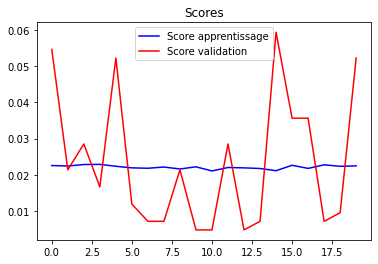

In [49]:
plot_scores(train)

# Conclusion

Dans le cas du dataset sur les panneaux de signalisation, on remrque que la méthode des ***réseaux de neurones denses*** (simples) et celle des ***réseaux de neurones profonds*** ont données de *bons résultats*. Cependant, le ***transfer learning*** avec le dataset pré-entraîné de *Imagenet* a plutôt fourni de mauvais scores, ce qui peut s'expliquer par le fait que le dataset sur *Imagenet ne s'est bien entraîné sur les images des panneaux de signalisation*.